# Simulate resting state dynamics in basic connectomes

This demo shows how to simulate and analyze resting state dynamics in mouse brain using as connectome a tracer-based connectome built thanks to the Allen Connectivity Builder.

The results showed here are discussed in Melozzi et al., 2016 [1]



First, we import all the required dependencies

In [1]:
from tvb.simulator.lab import *
LOG = get_logger('demo')
from tvb.simulator.plot.tools import *
import numpy as np
import pylab
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

INFO  log level set to INFO


## The Connectome

In order to built the mouse brain network we used a tracer-based connectome.

In particular we used a structural connectivity matrix (stored in the data folder of TVB), which is built thanks to the Allen Connectivity Builder in TVB.
The Allen Connectivity Builder is a tool that download and manipulate the open-source tracer experiments of the Allen Institute (Oh et al., 2014 [2]) in order to built a connectome and the corresponding parcelled volume according to the preferences of the user.

The user can choose:

  * the resolution of the grid volume in which the experimental data have been registered (here 100 $\mu m$).
  * The definition of the connection strength between source region $i$ and target region $j$. (here $w_{ij}=\frac{PD_j}{ID_i}$, where PD=projection density, ID=injection density)

It is possible to choose the characteristics of the brain areas to be included in the parcellation using the two following criteria:
 * Only brain areas where at least one injection has infected more than a given threshold of voxels. This kind of selection ensures that only the data with a certain level of experimental relevance is included in the connectome (Oh et al., 2014[2]), (here 50 voxels).
 * Only brain areas that have a volume greater than a given threshold can be included (here 2$mm^3$).



In the following the connectome is loaded in plotted. 
  

In [2]:
'''# Create a connectome. 

con = np.array([[2., 3., 0., 2.],
                       [2., 2., 0., 0.],
                       [0., 0., 2., 2.],
                       [2., 0., 0., 2.]])

con'''

# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file("C:\Users\Pok Him\Desktop\paupau.zip")

WARNING  File 'hemispheres' not found in ZIP.


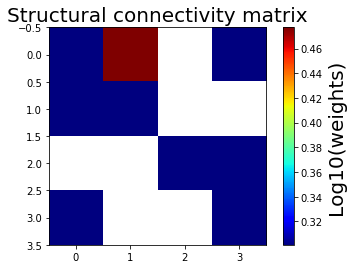

In [3]:
# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(con.weights), cmap='jet', aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)

## The simulation

Once the brain network is defined is possible to simulate its activity. Here we simulate resting state dynamics using the reduced Wong Wang model (Deco et al. 2013 [3], Hansen et al., 2015 [4]).

In order to convert the synaptic activity in BOLD signals we used the Balloon-Windkessel method (Friston et al., 200 [5]) using the default value implemented in The Virtual Brain.

In [14]:
# Set the parameter of the resting state simulation
sim = simulator.Simulator(model=models.ReducedWongWang(w=1.0, I_o=0.3),
                        connectivity=con,
                        coupling=coupling.Linear(a=0.096),
                        integrator=integrators.EulerStochastic(dt=0.1, noise=noise.Additive(nsig=0.000013)),
                        monitors=(monitors.Bold(period=2e3),
                                  monitors.TemporalAverage(period=1e3)),
                        simulation_length=1.2e5).configure()
# Run the resting state simulation
(bold_time, bold_data), _ = sim.run()

The simulated bold signals can be visualized using matplotlib library.

In [ ]:
# Display the simulated bold timeseries
plt.subplots()
plt.plot(bold_time,bold_data[:,0,:,0])
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated BOLD timeseries', fontsize=20)

## Analysis

The simulated BOLD signals can be analyzed in different way. 

### Functional Connectivity Matrix

Let's just do a static one


In [6]:
# Calculate Functional Connectivity Matrix = Pearson_correlation between possible time series.
'''
# import tvb.analyzers.cross_correlation as cc1
import tvb.analyzers.correlation_coefficient as cc2 
from tvb.datatypes.time_series import TimeSeriesRegion

# Build the time series object
tsr = TimeSeriesRegion(connectivity=sim.connectivity,
                       data=bold_data)
tsr.configure()


# CC1 = cc1.CrossCorrelate(time_series = tsr)
CC2 = cc2.CorrelationCoefficient(time_series = tsr, t_start = 1e4, t_end = 1.2e5)

Cc3 = CC2.evaluate()
plt.imshow(Cc3)
'''

INFO  result shape will be: (4L, 4L, 1L, 1L)


In [11]:
# 


TypeError: Image data cannot be converted to float

The original and segmented FCD matrices can be visualized using the matplotlib library.


Text(0.5,1,u'FCD segmented')

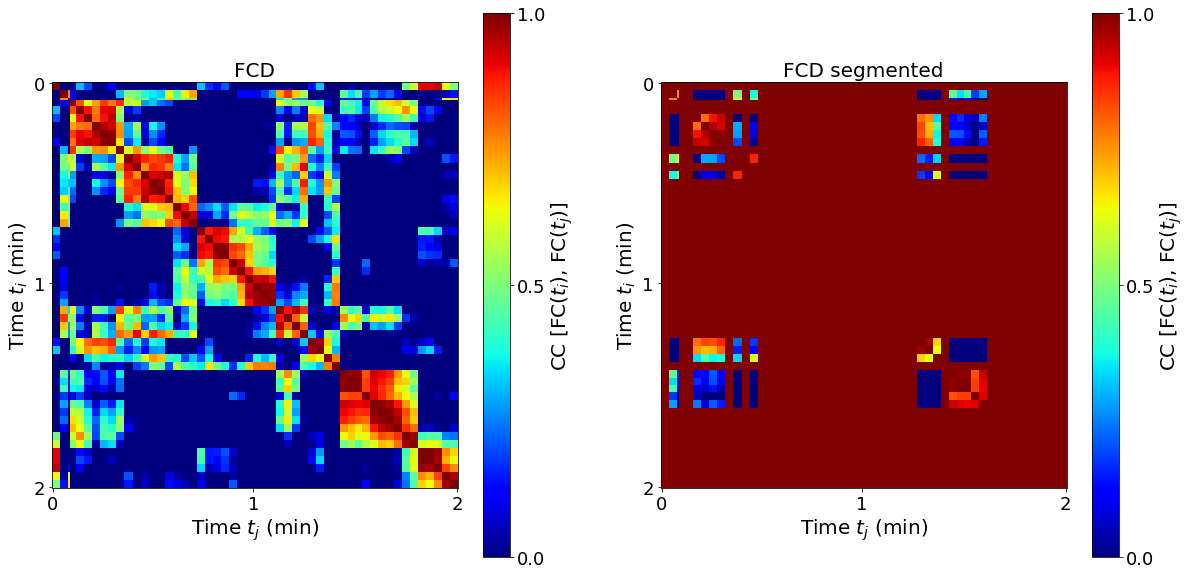

In [16]:
# Plot the FCD matrix and the FCD matrix segmented in the epochs
plt.subplot(121)
cs=plt.imshow(FCD, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','1', '2'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','1', '2'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD', fontsize=20)

plt.subplot(122)
cs=plt.imshow(FCD_segmented, cmap='jet', aspect='equal')
axcb =plt.colorbar(ticks=[0, 0.5, 1])
axcb.set_label(r'CC [FC($t_i$), FC($t_j$)]', fontsize=20)
cs.set_clim(0, 1.0)
for t in axcb.ax.get_yticklabels():
     t.set_fontsize(18)
plt.xticks([0,len(FCD)/2-1, len(FCD)-1],['0','1', '2'], fontsize=18)
plt.yticks([0,len(FCD)/2-1, len(FCD)-1],['0','1', '2'], fontsize=18)
plt.xlabel(r'Time $t_j$ (min)', fontsize=20)
plt.ylabel(r'Time $t_i$ (min)', fontsize=20)
plt.title('FCD segmented', fontsize=20)

### Functional hubs

The functional connectivity matrix of each epoch defines a functional network; for each functional network, TVB identifies the hub regions with an approach analogous to the one used in graph theory for defining the eigenvector centrality of a network node (Newman 2008 [7]). 

Here the functional hub regions of the mouse brain are defined as the regions with the largest eigenvector components, in absolute value, associated with the three largest eigenvalues of the FC matrix.


The functional hubs are an output of the FCD function (that we have just run), so we can save the results and display them in the mouse brain sections.

trying to read  D:\Program Files (x86)\TVB_Windows_1.5.8\TVB_Distribution\tvb_data\Lib\site-packages\tvb_data\mouse/allen_2mm/RegionVolumeMapping.h5
trying to read  D:\Program Files (x86)\TVB_Windows_1.5.8\TVB_Distribution\tvb_data\Lib\site-packages\tvb_data\mouse/allen_2mm/RegionVolumeMapping.h5
trying to read  D:\Program Files (x86)\TVB_Windows_1.5.8\TVB_Distribution\tvb_data\Lib\site-packages\tvb_data\mouse/allen_2mm/RegionVolumeMapping.h5
trying to read  D:\Program Files (x86)\TVB_Windows_1.5.8\TVB_Distribution\tvb_data\Lib\site-packages\tvb_data\mouse/allen_2mm/RegionVolumeMapping.h5
trying to read  D:\Program Files (x86)\TVB_Windows_1.5.8\TVB_Distribution\tvb_data\Lib\site-packages\tvb_data\mouse/allen_2mm/RegionVolumeMapping.h5
trying to read  D:\Program Files (x86)\TVB_Windows_1.5.8\TVB_Distribution\tvb_data\Lib\site-packages\tvb_data\mouse/allen_2mm/RegionVolumeMapping.h5
trying to read  D:\Program Files (x86)\TVB_Windows_1.5.8\TVB_Distribution\tvb_data\Lib\site-packages\tvb_d

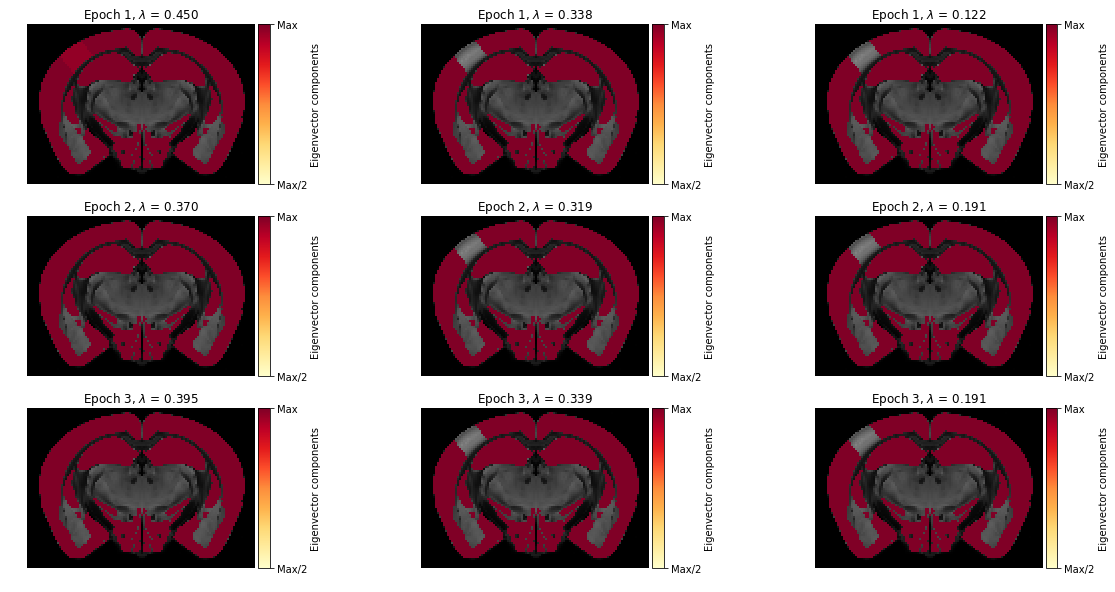

In [17]:
# Save the functional hubs calculated as output of the FCD function
Eigvect_dict=fcd_data[2]
Eigval_dict=fcd_data[3]

# Plot the functional hubs extracted in the epochs

import h5py
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tvb.basic.readers import try_get_absolute_path

fig, axes = plt.subplots(3,3)

mode=0
var=0
count=1
slice_idy=73
for ep in range(3):
    for eigval in range(3):
        f_path = try_get_absolute_path("tvb_data", "mouse/allen_2mm/RegionVolumeMapping.h5")
        print "trying to read ", f_path
        f = h5py.File(f_path, 'r', libver='latest')
        Vol=f['array_data'][:,:,:]
        f_path = try_get_absolute_path("tvb_data", "mouse/allen_2mm/StructuralMRI.h5")
        f = h5py.File(f_path, 'r', libver='latest')
        template=f['array_data'][:,:,:]
        lambda_=Eigval_dict[mode][var][ep+1][eigval]
        eig=Eigvect_dict[mode][var][ep+1][eigval] 

        for i in range(np.shape(eig)[0]):
            Vol[Vol==i]=eig[i]
        Vol = np.ma.masked_where(Vol < (np.amax(eig)/2), Vol)        
        im1 = axes[ep,eigval].imshow((template[:,slice_idy,:].T)[::-1], cmap='gray', vmin=template.min(), vmax=template.max())
        cax = axes[ep,eigval].imshow((Vol[:,slice_idy,:].T)[::-1], cmap='YlOrRd', alpha=1, vmin=np.amax(eig)/2., vmax=np.amax(eig))
        axes[ep,eigval].axis('off')
        axes[ep,eigval].set_title(r'Epoch %s, $\lambda$ = %1.3f'%(ep+1,lambda_))
        divider = make_axes_locatable(axes[ep,eigval])
        cax1 = divider.append_axes("right", size="5%", pad=0.05)
        axcb=plt.colorbar(cax,cax1,ticks=[np.amax(eig)/2.,np.amax(eig)],orientation='vertical')
        axcb.set_ticklabels(['Max/2', 'Max']) 
        axcb.set_label('Eigenvector components')

## References

[1] Melozzi, Francesca, Marmaduke Woodman, Viktor Jirsa, and Christophe Bernard. "The Virtual Mouse Brain: A Computational Neuroinformatics Platform To Study Whole Mouse Brain Dynamics." bioRxiv (2017): 123406.


[2] Oh, Seung Wook, Julie A. Harris, Lydia Ng, Brent Winslow, Nicholas Cain, Stefan Mihalas, Quanxin Wang et al. "A mesoscale connectome of the mouse brain." Nature 508, no. 7495 (2014): 207-214.


[3] Deco Gustavo, Ponce Alvarez Adrian, Dante Mantini, Gian Luca Romani, Patric Hagmann and Maurizio Corbetta. Resting-State Functional Connectivity Emerges from Structurally and Dynamically Shaped Slow Linear Fluctuations. The Journal of Neuroscience 32(27), 11239-11252, 2013.


[4] Hansen, Enrique CA, Demian Battaglia, Andreas Spiegler, Gustavo Deco, and Viktor K. Jirsa. "Functional connectivity dynamics: modeling the switching behavior of the resting state." Neuroimage 105 (2015): 525-535.


[5] Friston, Karl J., Andrea Mechelli, Robert Turner, and Cathy J. Price. "Nonlinear responses in fMRI: the Balloon model, Volterra kernels, and other hemodynamics." NeuroImage 12, no. 4 (2000): 466-477.


[6] Preti, Maria Giulia, Thomas AW Bolton, and Dimitri Van De Ville. "The dynamic functional connectome: State-of-the-art and perspectives." NeuroImage (2016).


[7] Newman, Mark EJ. "The mathematics of networks." The new palgrave encyclopedia of economics 2, no. 2008 (2008): 1-12.